## Сбор данных с сайта "Яндекс Дзен"

In [1]:
import requests
from bs4 import BeautifulSoup
import json
import re
import pandas as pd
from datetime import datetime, timedelta
from sqlalchemy import create_engine
import traceback

cookies = {
    'news_lang': 'ru',
    'nc': 'tips=1669116675432%3Bfavorites-button:1',
    'sso_checked': '1',
    'yandex_login': '',
    'yandexuid': '4418883751668766953',
    '_yasc': 'bvYHi8GFr6wiVgwnzIGbRxV1jmn9isOWGNAJOxGLT7gEOCeBN0eS96hYsvk=',
    '_ym_uid': '16687727324320845',
    '_ym_d': '1668772732',
    'vid': 'c4a038b4868be81c',
    'Session_id': 'noauth:1669019784',
    'mda2_beacon': '1669019784785',
    '_ym_isad': '2',
    'tmr_lvid': '52390132f1b93bbd91c4c20fb582a7b7',
    'tmr_lvidTS': '1668772731725',
    'tmr_detect': '0%7C1669277547765',
}

headers = {
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'Accept-Language': 'ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7',
    'Cache-Control': 'max-age=0',
    'Connection': 'keep-alive',
    # Requests sorts cookies= alphabetically
    # 'Cookie': 'news_lang=ru; nc=tips=1669116675432%3Bfavorites-button:1; sso_checked=1; yandex_login=; yandexuid=4418883751668766953; _yasc=bvYHi8GFr6wiVgwnzIGbRxV1jmn9isOWGNAJOxGLT7gEOCeBN0eS96hYsvk=; _ym_uid=16687727324320845; _ym_d=1668772732; vid=c4a038b4868be81c; Session_id=noauth:1669019784; mda2_beacon=1669019784785; _ym_isad=2; tmr_lvid=52390132f1b93bbd91c4c20fb582a7b7; tmr_lvidTS=1668772731725; tmr_detect=0%7C1669277547765',
    'Referer': 'https://dzen.ru/news?issue_tld=ru',
    'Sec-Fetch-Dest': 'document',
    'Sec-Fetch-Mode': 'navigate',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-User': '?1',
    'Upgrade-Insecure-Requests': '1',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36',
    'sec-ch-ua': '"Google Chrome";v="107", "Chromium";v="107", "Not=A?Brand";v="24"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
}

# Функция для обработки и вывода времени
def parse_date(s_date):
    months = {'января': '01',
              'февраля': '02',
              'марта': '03',
              'апреля': '04',
              'мая': '05',
              'июня': '06',
              'июля': '07',
              'августа': '08',
              'сентября': '09',
              'октября': '10',
              'ноября': '11',
              'декабря': '12',
              }
    
    row_date = s_date.split(' в')[0]
    month_ = row_date.split(' ')[1].strip(' ')
    date_num = re.search(r'\d{2}', row_date).group(0)
    date = f"{date_num}.{months[month_]}.2022"
    return date

### Сбор новостей по рубрикам

In [2]:
def parse_rubrics():
    rubrics = ['Политика', 'Армия и оружие', 'Общество', 'ЖКХ', 'Религия', 'Экология', 'Здоровье', 'Путешествия', 
               'Транспорт', 'Экономика', 'Энергетика', 'Недвижимость', 'Финансы', 'В мире', 'Спорт', 'Автоспорт',
               'Баскетбол', 'Футбол', 'Хоккей', 'Фигурное катание', 'Происшествия', 'Культура', 'Театры', 'Музыка',
               'Кино', 'Технологии', 'Игры', 'Гаджеты', 'Интернет', 'Наука', 'Космос']
    rubrics_links = ['rubric/politics', 'rubric/army', 'rubric/society', 'rubric/communal', 'rubric/religion',
                     'rubric/ecology', 'rubric/health', 'rubric/travels', 'rubric/vehicle',  'rubric/business',
                     'rubric/energy', 'rubric/realty', 'rubric/finances', 'rubric/world', 'rubric/sport',
                     'rubric/auto_racing', 'rubric/basketball', 'rubric/football', 'rubric/hockey',
                     'rubric/figure_skating', 'rubric/incident', 'rubric/culture', 'rubric/theaters',
                     'rubric/music', 'rubric/movies', 'rubric/computers', 'rubric/games', 'rubric/gadgets',
                     'rubric/internet', 'rubric/science', 'rubric/cosmos']

    rubricsAndLinks = list(zip(rubrics, rubrics_links))
    df_rubricsAndLinks = pd.DataFrame(rubricsAndLinks, columns=['rubric', 'rubric_link'])

    session = requests.Session()
    session.headers.update(headers)
    session.cookies.update(cookies)

    dates = []
    times = []
    data = []
    stories = []

    for i, row in df_rubricsAndLinks.iterrows():
        link = row['rubric_link']
        r = session.get(f'https://dzen.ru/news/{link}?issue_tld=ru')

        soup = BeautifulSoup(r.text)
        script_text = soup.find_all('script')[3].contents[0]
        data = json.loads(re.search(r"window.Ya.Neo.dataSource=({.*?});", script_text, flags=re.S).group(1))

        story_rubric = row['rubric']
    
        for stories_top in data['news']['top']:
        
            story_id = stories_top['id']
            story_title = stories_top['title']
            story_annotation = stories_top['annotation']
            story_url = stories_top['url']
            instory_url = story_url.replace('/story/', '/instory/')
            story_time = stories_top['time']
            if 'вчера' in story_time:
                date = (datetime.now() - timedelta(days=1)).strftime('%d.%m.%Y')
                time = re.search(r'(?<=вчера в )\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            elif re.search(r'\d{2} \w+ \w+ \d{2}:\d{2}', story_time) is not None:
                date = parse_date(story_time)
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            else:
                date = datetime.now().strftime('%d.%m.%Y')
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
        
            stories.append([story_rubric, story_id, story_title, story_annotation, story_url, instory_url, story_time])
    
        for stories_feed in data['news']['feed']:
        
            story_id = stories_feed['id']
            story_title = stories_feed['title']
            story_annotation = stories_feed['annotation']
            story_url = stories_feed['url']
            instory_url = story_url.replace('/story/', '/instory/')
            story_time = stories_feed['time']
            if 'вчера' in story_time:
                date = (datetime.now() - timedelta(days=1)).strftime('%d.%m.%Y')
                time = re.search(r'(?<=вчера в )\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            elif re.search(r'\d{2} \w+ \w+ \d{2}:\d{2}', story_time) is not None:
                date = parse_date(story_time)
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            else:
                date = datetime.now().strftime('%d.%m.%Y')
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
        
            stories.append([story_rubric, story_id, story_title, story_annotation, story_url, instory_url, story_time])
    
    
    story_headers = ['rubric', 'id', 'title', 'annotation', 'story_url', 'instory_url', 'time']
    df_stories = pd.DataFrame(stories, columns=story_headers)

    return df_stories

### Сбор похожих новостей при переходе к каждой новости (instory) (с рубриками и подрубриками)

In [3]:
def parse_main():
    df_stories = parse_rubrics()
    df_instory = df_stories[['rubric', 'id', 'instory_url']]
    more_stories = []
    
    session = requests.Session()
    session.headers.update(headers)
    session.cookies.update(cookies)

    for i, row in df_stories.iterrows():
        url = row['instory_url']
        more = session.get(url)
        more_soup = BeautifulSoup(more.text)
        more_script_text = more_soup.find_all('script')[3].contents[0]
        more_data = json.loads(re.search(r"window.Ya.Neo.dataSource=({.*?});", more_script_text, flags=re.S).group(1))
                               
        more_info = more_data['news']['instoryPage'][0]
        docs = more_info['docs']
    
        more_rubric = row['rubric']
        more_idMain = row['id']
        more_instoryUrl = row['instory_url']
            
        for doc in docs:
        
            more_id = doc['docId']
            more_title = doc['title'][0]['text']  
            more_text = doc['text'][0]['text'] 
            more_source = doc['sourceName']
            more_url = doc['url']
            more_time = doc['time']
            if 'вчера' in more_time:
                date = (datetime.now() - timedelta(days=1)).strftime('%d.%m.%Y')
                time = re.search(r'(?<=вчера в )\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
            elif re.search(r'\d{2} \w+ \w+ \d{2}:\d{2}', more_time) is not None:
                date = parse_date(more_time)
                time = re.search(r'\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
            else:
                date = datetime.now().strftime('%d.%m.%Y')
                time = re.search(r'\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
   
            more_stories.append([more_rubric, more_idMain, more_title, more_text, more_source, more_instoryUrl, more_url, more_time])
            
    more_stories_headers = ['rubric', 'story_id', 'title', 'text', 'sourceName', 'instory_url', 'url', 'time']
    df_more_stories = pd.DataFrame(more_stories, columns=more_stories_headers)
    
    main_rubrics = []
    for i, row in df_more_stories.iterrows():
        if row['rubric'] == 'Политика' or row['rubric'] == 'Армия и оружие':
            main_rubric = 'Политика'
        elif row['rubric'] == 'Общество' or row['rubric'] == 'ЖКХ' or row['rubric'] == 'Религия' or row['rubric'] == 'Экология' or row['rubric'] == 'Здоровье' or row['rubric'] == 'Путешествия' or row['rubric'] == 'Транспорт':
            main_rubric = 'Общество'
        elif row['rubric'] == 'Экономика' or row['rubric'] == 'Энергетика' or row['rubric'] == 'Недвижимость' or row['rubric'] == 'Финансы':
            main_rubric = 'Экономика'
        elif row['rubric'] == 'В мире':
            main_rubric = 'В мире'
        elif row['rubric'] == 'Спорт' or row['rubric'] == 'Автоспорт' or row['rubric'] == 'Баскетбол' or row['rubric'] == 'Футбол' or row['rubric'] == 'Хоккей' or row['rubric'] == 'Фигурное катание':
            main_rubric = 'Спорт'
        elif row['rubric'] == 'Происшествия':
            main_rubric = 'Происшествия'
        elif row['rubric'] == 'Культура' or row['rubric'] == 'Театры' or row['rubric'] == 'Музыка' or row['rubric'] == 'Кино':
            main_rubric = 'Культура'
        elif row['rubric'] == 'Технологии' or row['rubric'] == 'Игры' or row['rubric'] == 'Гаджеты' or row['rubric'] == 'Интернет':
            main_rubric = 'Технологии'
        elif row['rubric'] == 'Наука' or row['rubric'] == 'Космос':
            main_rubric = 'Наука'
        else:
            main_rubric = 'Другое'
        
        main_rubrics.append(main_rubric)
                             
    df_more_stories.insert(loc=0, column='main_rubric', value=main_rubrics)
    return df_more_stories

### Сбор похожих новостей (только с рубриками)

In [ ]:
def parse_main_1():
    df_stories = parse_rubrics()
    df_instory = df_stories[['rubric', 'id', 'instory_url']]
    more_stories = []
    
    session = requests.Session()
    session.headers.update(headers)
    session.cookies.update(cookies)

    for i, row in df_stories.iterrows():
        url = row['instory_url']
        more = session.get(url)
        more_soup = BeautifulSoup(more.text)
        more_script_text = more_soup.find_all('script')[3].contents[0]
        more_data = json.loads(re.search(r"window.Ya.Neo.dataSource=({.*?});", more_script_text, flags=re.S).group(1))
                               
        more_info = more_data['news']['instoryPage'][0]
        docs = more_info['docs']
    
        more_rubric = row['rubric']
        more_idMain = row['id']
        more_instoryUrl = row['instory_url']
            
        for doc in docs:
        
            more_id = doc['docId']
            more_title = doc['title'][0]['text']  
            more_text = doc['text'][0]['text'] 
            more_source = doc['sourceName']
            more_url = doc['url']
            more_time = doc['time']
            if 'вчера' in more_time:
                date = (datetime.now() - timedelta(days=1)).strftime('%d.%m.%Y')
                time = re.search(r'(?<=вчера в )\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
            elif re.search(r'\d{2} \w+ \w+ \d{2}:\d{2}', more_time) is not None:
                date = parse_date(more_time)
                time = re.search(r'\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
            else:
                date = datetime.now().strftime('%d.%m.%Y')
                time = re.search(r'\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
   
            more_stories.append([more_rubric, more_idMain, more_title, more_text, more_source, more_instoryUrl, more_url, more_time])
        
    more_stories_headers = ['rubric', 'story_id', 'title', 'text', 'sourceName', 'instory_url', 'url', 'time']
    df_more_stories = pd.DataFrame(more_stories, columns=more_stories_headers)

    return df_more_stories

## Разведочный анализ данных

In [4]:
%%time
df_parse = parse_main()
df_nlp = df_parse.loc[:, ['main_rubric','rubric','title','text']]

#df_nlp

CPU times: user 32 s, sys: 1.77 s, total: 33.8 s
Wall time: 2min 38s


In [5]:
# Информация о данных
df_nlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3844 entries, 0 to 3843
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   main_rubric  3844 non-null   object
 1   rubric       3844 non-null   object
 2   title        3844 non-null   object
 3   text         3844 non-null   object
dtypes: object(4)
memory usage: 120.2+ KB


In [6]:
# Кол-во пропусков во всем датафрейме
df_nlp.isnull().sum()

main_rubric    0
rubric         0
title          0
text           0
dtype: int64

<div class="alert alert-success"><b>Пропусков в данных нет</b>

In [7]:
# Статистика распределения значений в столбце rubric в % виде
df_nlp['rubric'].value_counts(normalize=True)

Происшествия        0.158949
Армия и оружие      0.057492
В мире              0.048907
Общество            0.042664
Политика            0.036420
Здоровье            0.036160
Футбол              0.031738
Хоккей              0.031478
Наука               0.030957
Технологии          0.030957
Культура            0.030957
Спорт               0.030437
Экономика           0.029396
Энергетика          0.028356
Игры                0.027836
Космос              0.027315
Путешествия         0.026795
Фигурное катание    0.026535
Гаджеты             0.026015
Финансы             0.025494
ЖКХ                 0.024974
Транспорт           0.024714
Недвижимость        0.024194
Кино                0.024194
Автоспорт           0.023673
Музыка              0.022893
Баскетбол           0.017690
Театры              0.017430
Интернет            0.015349
Религия             0.015088
Экология            0.004943
Name: rubric, dtype: float64

In [8]:
# Статистика распределения этих значений в столбце main_rubric в % виде
df_nlp['main_rubric'].value_counts(normalize=True)

Общество        0.175338
Спорт           0.161550
Происшествия    0.158949
Экономика       0.107440
Технологии      0.100156
Культура        0.095473
Политика        0.093913
Наука           0.058273
В мире          0.048907
Name: main_rubric, dtype: float64

In [9]:
# Исследование столбца rubric
print('Кол-во уникальных значений: ', df_nlp['rubric'].nunique())
print('Список уникальных значений: ', df_nlp['rubric'].unique())
print('Статистика распределения значений: ', df_nlp['rubric'].value_counts(normalize=False))

Кол-во уникальных значений:  31
Список уникальных значений:  ['Политика' 'Армия и оружие' 'Общество' 'ЖКХ' 'Религия' 'Экология'
 'Здоровье' 'Путешествия' 'Транспорт' 'Экономика' 'Энергетика'
 'Недвижимость' 'Финансы' 'В мире' 'Спорт' 'Автоспорт' 'Баскетбол'
 'Футбол' 'Хоккей' 'Фигурное катание' 'Происшествия' 'Культура' 'Театры'
 'Музыка' 'Кино' 'Технологии' 'Игры' 'Гаджеты' 'Интернет' 'Наука' 'Космос']
Статистика распределения значений:  Происшествия        611
Армия и оружие      221
В мире              188
Общество            164
Политика            140
Здоровье            139
Футбол              122
Хоккей              121
Наука               119
Технологии          119
Культура            119
Спорт               117
Экономика           113
Энергетика          109
Игры                107
Космос              105
Путешествия         103
Фигурное катание    102
Гаджеты             100
Финансы              98
ЖКХ                  96
Транспорт            95
Недвижимость         93
Кино 

In [10]:
# Исследование столбца main_rubric
print('Кол-во уникальных значений: ', df_nlp['main_rubric'].nunique())
print('Список уникальных значений: ', df_nlp['main_rubric'].unique())
print('Статистика распределения значений: ', df_nlp['main_rubric'].value_counts(normalize=False))

Кол-во уникальных значений:  9
Список уникальных значений:  ['Политика' 'Общество' 'Экономика' 'В мире' 'Спорт' 'Происшествия'
 'Культура' 'Технологии' 'Наука']
Статистика распределения значений:  Общество        674
Спорт           621
Происшествия    611
Экономика       413
Технологии      385
Культура        367
Политика        361
Наука           224
В мире          188
Name: main_rubric, dtype: int64


<div class="alert alert-success"><b>Вывод: вид задачи - многоклассовая классификация</b>

In [11]:
# Описательная статистика для всех признаков 
df_nlp.describe().T

,count,unique,top,freq
main_rubric,3844,9,Общество,674
rubric,3844,31,Происшествия,611
title,3844,3380,Shukan Gendai: украинский конфликт стал причин...,6
text,3844,3433,Рубль в начале торговой сессии пятницы снижает...,4


### Визульный анализ

<AxesSubplot:>

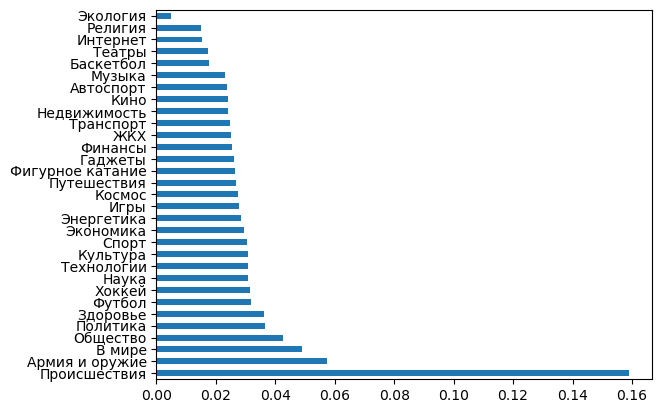

In [12]:
# Горизонтальная столбчатая диаграмма для столбца rubric
df_nlp['rubric'].value_counts(normalize=True).plot.barh()

<AxesSubplot:>

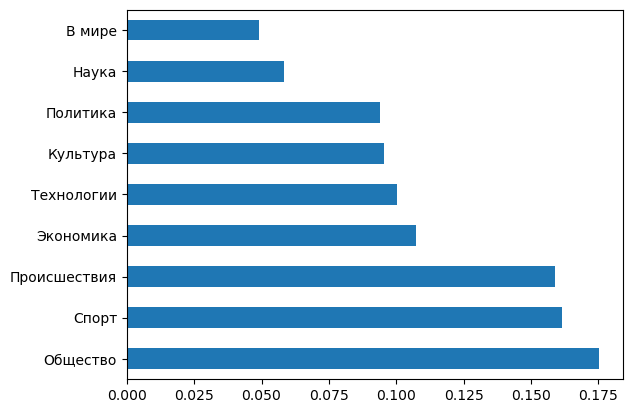

In [13]:
# Горизонтальная столбчатая диаграмма для столбца main_rubric
df_nlp['main_rubric'].value_counts(normalize=True).plot.barh()

In [14]:
df_nlp['rubric'].value_counts()

Происшествия        611
Армия и оружие      221
В мире              188
Общество            164
Политика            140
Здоровье            139
Футбол              122
Хоккей              121
Наука               119
Технологии          119
Культура            119
Спорт               117
Экономика           113
Энергетика          109
Игры                107
Космос              105
Путешествия         103
Фигурное катание    102
Гаджеты             100
Финансы              98
ЖКХ                  96
Транспорт            95
Недвижимость         93
Кино                 93
Автоспорт            91
Музыка               88
Баскетбол            68
Театры               67
Интернет             59
Религия              58
Экология             19
Name: rubric, dtype: int64

In [15]:
df_nlp['main_rubric'].value_counts()

Общество        674
Спорт           621
Происшествия    611
Экономика       413
Технологии      385
Культура        367
Политика        361
Наука           224
В мире          188
Name: main_rubric, dtype: int64

## Обработка естественного языка NLP

Действия, выполняемые в процессе:

* удаление пробельных символов;
* стемминг;
* удаление стоп-слов;
* лемматизация.

In [21]:
# Функция для удаления пробельных символов
import string
import re
from nltk.corpus import stopwords

def remove_punctuation(text):
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])
def remove_numbers(text):
    return ''.join([i if not i.isdigit() else ' ' for i in text])
def remove_multiple_spaces(text):
    return re.sub(r'\s+', ' ', text, flags=re.I)

def delete_char(): 
    prep_text = [remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower()))) for text in df_nlp['text']]
    prep_title = [remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower()))) for text in df_nlp['title']]
    df_nlp["text_prep"] = prep_text
    df_nlp["title_prep"] = prep_title
    return df_nlp


#Функция для стемматизации
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize

def stemmed_text():
    stemmer = SnowballStemmer("russian")
    russian_stopwords = stopwords.words("russian")
    russian_stopwords.extend(['…', '...', 'т.д.', 'т', 'д', '«', '»'])

    stemmed_texts_list = []
    stemmed_titles_list = []
    
    for text in df_nlp["text_prep"]:
        tokens = word_tokenize(text)
        stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in russian_stopwords]
        text = " ".join(stemmed_tokens)
        stemmed_texts_list.append(text)
    
    df_nlp["text_stem"] = stemmed_texts_list
    
    for text in df_nlp["title_prep"]:
        tokens = word_tokenize(text)
        stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in russian_stopwords]
        text = " ".join(stemmed_tokens)
        stemmed_titles_list.append(text)
    
    df_nlp["title_stem"] = stemmed_titles_list
    
    return df_nlp


#Функция для удаления стоп-слов
from nltk import word_tokenize

def stopword_text():
    russian_stopwords = stopwords.words("russian")
    russian_stopwords.extend(['…', '...', 'т.д.', 'т', 'д', '«', '»'])
    
    sw_texts_list = []
    sw_titles_list = []
    
    for text in df_nlp['text_prep']:
        tokens = word_tokenize(text)
        tokens = [token for token in tokens if token not in russian_stopwords and token != ' ']
        text = " ".join(tokens)
        sw_texts_list.append(text)

    df_nlp["text_sw"] = sw_texts_list
    
    for text in df_nlp['title_prep']:
        tokens = word_tokenize(text)
        tokens = [token for token in tokens if token not in russian_stopwords and token != ' ']
        text = " ".join(tokens)
        sw_titles_list.append(text)
        
    df_nlp["title_sw"] = sw_titles_list
    
    return df_nlp


#Функция для лемматизации
from pymystem3 import Mystem

def lemmatize_text():
    mystem = Mystem()
    
    lemm_texts_list = []
    lemm_titles_list = []
    
    russian_stopwords = stopwords.words("russian")
    russian_stopwords.extend(['…', '...', 'т.д.', 'т', 'д', '«', '»'])
    text1 = ""
    text2 = ""

    text_list = df_nlp['text_sw'].to_list()
    text_join = "joining".join(text_list)
    
    title_list = df_nlp['title_sw'].to_list()
    title_join = "joining".join(title_list)

    try:
        text_lem = mystem.lemmatize(text_join)
        tokens1 = [token for token in text_lem if token != ' ' and token not in russian_stopwords]
        text1 = " ".join(tokens1)
        
        title_lem = mystem.lemmatize(title_join)
        tokens2 = [token for token in title_lem if token != ' ' and token not in russian_stopwords]
        text2 = " ".join(tokens2)
        
    except Exception as e:
        print(e)

    text1_split = text1.split("joining")
    df_nlp["text_lemm"] = text1_split
    text2_split = text2.split("joining")
    df_nlp["title_lemm"] = text2_split
    
    return df_nlp

    
#Функция для балансировки классов
def nlp(df):
    delete_char()
    stemmed_text()
    stopword_text()
    lemmatize_text()
    
    df_pr = df.loc[df['main_rubric'] == 'Происшествия'].head(200)
    df_other = df.loc[df['main_rubric'] != 'Происшествия']
    df = pd.concat([df_pr, df_other])
    return df

In [22]:
df_nlp = nlp(df_nlp)
df_nlp

,main_rubric,rubric,title,text,text_prep,title_prep,text_stem,title_stem,text_sw,title_sw,text_lemm,title_lemm
2257,Происшествия,Происшествия,ТАСС: в ЛНР во время обстрела погибли восемь ч...,Восемь человек погибли и 23 пострадали в резул...,восемь человек погибли и пострадали в результа...,тасс в лнр во время обстрела погибли восемь че...,восем человек погибл пострада результат обстре...,тасс лнр врем обстрел погибл восем человек,восемь человек погибли пострадали результате о...,тасс лнр время обстрела погибли восемь человек,восемь человек погибать пострадать результат о...,тасс лнр время обстрел погибать восемь человек
2258,Происшествия,Происшествия,ТАСС: при обстреле ВСУ Лантратовки в ЛНР погиб...,А буквально сегодня ночью вновь обстреляли мир...,а буквально сегодня ночью вновь обстреляли мир...,тасс при обстреле всу лантратовки в лнр погибл...,буквальн сегодн ноч внов обстреля мирн поселок...,тасс обстрел всу лантратовк лнр погибл восем ч...,буквально сегодня ночью вновь обстреляли мирны...,тасс обстреле всу лантратовки лнр погибли восе...,буквально сегодня ночь вновь обстреливать мирн...,тасс обстрел всу лантратовка лнр погибать восе...
2259,Происшествия,Происшествия,В результате обстрела ВСУ Лантратовки в ЛНР по...,В результате обстрела населённого пункта Лантр...,в результате обстрела населённого пункта лантр...,в результате обстрела всу лантратовки в лнр по...,результат обстрел населен пункт лантратовк луг...,результат обстрел всу лантратовк лнр погибл во...,результате обстрела населённого пункта лантрат...,результате обстрела всу лантратовки лнр погибл...,результате обстрел населенный пункт лантратовк...,результате обстрел всу лантратовка лнр погибат...
2260,Происшествия,Происшествия,При обстреле села Лантратовка в ЛНР украинским...,Украинская армия нанесла удары по селу Лантрат...,украинская армия нанесла удары по селу лантрат...,при обстреле села лантратовка в лнр украинским...,украинск арм нанесл удар сел лантратовк луганс...,обстрел сел лантратовк лнр украинск боевик пог...,украинская армия нанесла удары селу лантратовк...,обстреле села лантратовка лнр украинскими боев...,украинская армия наносить удар село лантратовк...,обстреле садиться лантратовка лнр украинский б...
2261,Происшествия,Происшествия,При обстреле ВСУ села Лантратовка в ЛНР погибл...,В результате обстрела украинскими националиста...,в результате обстрела украинскими националиста...,при обстреле всу села лантратовка в лнр погибл...,результат обстрел украинск националист населен...,обстрел всу сел лантратовк лнр погибл человек,результате обстрела украинскими националистами...,обстреле всу села лантратовка лнр погибли человек,результате обстрел украинский националист насе...,обстреле всу садиться лантратовка лнр погибать...
...,...,...,...,...,...,...,...,...,...,...,...,...
3839,Наука,Космос,Китай потерял 14 спутников при запуске первой ...,Китай не сумел успешно осуществить запуск перв...,китай не сумел успешно осуществить запуск перв...,китай потерял спутников при запуске первой мет...,кита сумел успешн осуществ запуск перв метанов...,кита потеря спутник запуск перв метанов орбита...,китай сумел успешно осуществить запуск первой ...,китай потерял спутников запуске первой метанов...,китай суметь успешно осуществлять запуск первы...,китай потерять спутник запуск первый метановый...
3840,Наука,Космос,Старт первой в мире ракеты на метане «Чжуцюэ-2...,"14 спутников, которые находились на борту раке...",спутников которые находились на борту ракеты ...,старт первой в мире ракеты на метане «чжуцюэ »...,спутник котор наход борт ракет потеря,старт перв мир ракет метан чжуцюэ законч провал,спутников которые находились борту ракеты поте...,старт первой мире ракеты метане чжуцюэ закончи...,спутников который находиться борт ракета потеряны,старт первый мир ракета метан чжуцюэ заканчива...
3841,Наука,Космос,Первый орбитальный запуск ракеты на жидком мет...,Помимо испытания нового типа двигателей целью ...,помимо испытания нового типа двигателей целью ...,первый о

<AxesSubplot:>

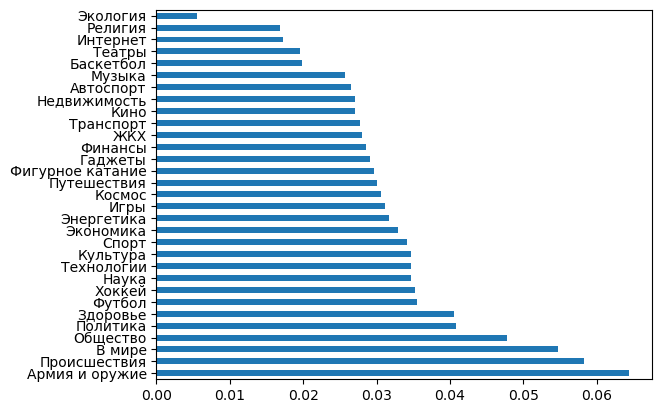

In [23]:
# Горизонтальная столбчатая диаграмма для rubric
df_nlp['rubric'].value_counts(normalize=True).plot.barh()

<AxesSubplot:>

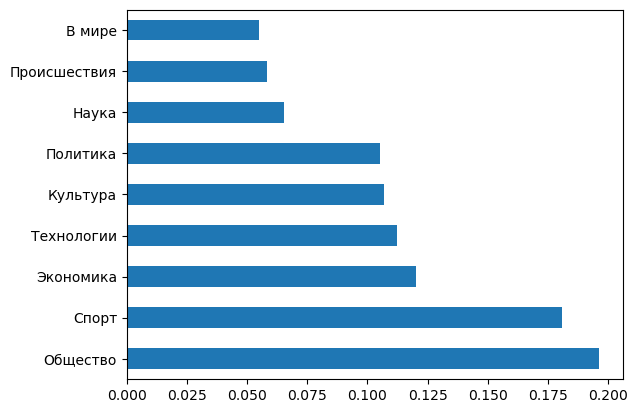

In [24]:
# Горизонтальная столбчатая диаграмма для main_rubric
df_nlp['main_rubric'].value_counts(normalize=True).plot.barh()

### Сохранение данных в формате csv

In [25]:
# Для mac
df_nlp.to_csv('/Users/user/Documents/ML.csv')

# Для win
#df_nlp.to_csv(r'C:\Users\User\Downloads\ML.csv')
# Выражение, добавляющее к БД только новые новости
#res = df1[~df1['url'].isin(df2['url'])]